<H1>MADATORY PYTHON LIBRARIES</H1>

In [59]:
import xarray
import pandas as pd
import folium
import os
import numpy as np
from folium import plugins
%matplotlib  inline

<h1>IN SITU PROFILERS</h1>

In Situ 'profilers' comprehends a wide range of devices able to drift with the currents as well as submerge every now and then in the watter column reporting certain parameters along its trajectory. In Situ profilers produce only PR data (profiles) and its platform data source is PF. <a href="https://youtu.be/WGbanFvBX38" traget="_blank">More info</a>

## 1. In Situ netCDF

Imagine you have downloaded some <i>_PR_ (profile)</i> dataset from In Situ profilers (see how to download files from a certain [platform data source](https://github.com/CopernicusMarineInsitu/INSTAC-Tarining-Phase2/blob/master/PythonNotebook/In_Situ_data_download_by_platform_data_source.ipynb) or [platform category](https://github.com/CopernicusMarineInsitu/INSTAC-Tarining-Phase2/blob/master/PythonNotebooks/In_Situ_data_download_by_platform_type.ipynb)) like: [MO_PR_PF_6901885.nc](ftp://nrt.cmems-du.eu/Core/INSITU_MED_NRT_OBSERVATIONS_013_035/history/profiler-glider/MO_PR_PF_6901885.nc)

In [60]:
dataset = 'MO_PR_PF_6901885.nc'

Let's have a look to its content:

In [61]:
full_path2file = os.getcwd()+'/'+dataset #default to current directory
print('path2file: %s'%(full_path2file))

path2file: /home/protllan/code/Training/INSTACTraining-PhaseII/PythonNotebooks/MO_PR_PF_6901885.nc


In [62]:
ds = xarray.open_dataset(dataset)

ds contains all the information about the dataset (relevant metadata, variables, dimensions etc):

In [63]:
ds

<xarray.Dataset>
Dimensions:      (DEPTH: 400, LATITUDE: 230, LONGITUDE: 230, POSITION: 230, TIME: 230)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2014-10-19T12:45:40.003200 ...
  * LATITUDE     (LATITUDE) float64 35.69 35.65 35.73 35.72 35.85 36.02 36.1 ...
  * LONGITUDE    (LONGITUDE) float64 25.01 25.02 25.49 25.58 25.85 25.77 ...
Dimensions without coordinates: DEPTH, POSITION
Data variables:
    TIME_QC      (TIME) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    POSITION_QC  (POSITION) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    DATA_MODE    (TIME) object 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' ...
    DIRECTION    (TIME) object 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' ...
    PRES         (TIME, DEPTH) float64 2.1 2.9 4.0 5.0 6.0 7.0 8.0 9.0 10.1 ...
    PRES_QC      (TIME, DEPTH) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    TEMP         (TIME, DEPTH) float64 23.17 23.17 23.17 23.17 23.17 23.17 ...
    TEMP_QC      (TIME, DEPTH) floa

In [64]:
ds.variables.keys()

[u'TIME',
 u'TIME_QC',
 u'LATITUDE',
 u'LONGITUDE',
 u'POSITION_QC',
 u'DATA_MODE',
 u'DIRECTION',
 u'PRES',
 u'PRES_QC',
 u'TEMP',
 u'TEMP_QC',
 u'PSAL',
 u'PSAL_QC']

Every of the above parameters varies along certain dimensions (within parenthesis when checking the parameter metadata):

In [65]:
ds['LATITUDE']

<xarray.DataArray 'LATITUDE' (LATITUDE: 230)>
array([ 35.694523,  35.64505 ,  35.731743, ...,  35.814137,  35.993549,
        35.743042])
Coordinates:
  * LATITUDE  (LATITUDE) float64 35.69 35.65 35.73 35.72 35.85 36.02 36.1 ...
Attributes:
    long_name:                   Latitude of each location
    standard_name:               latitude
    units:                       degree_north
    valid_min:                   -90.0
    valid_max:                   90.0
    QC_indicator:                1
    QC_procedure:                1
    uncertainty:                  
    comment:                      
    axis:                        Y
    reference:                   WGS84
    coordinate_reference_frame:  urn:ogc:crs:EPSG::4326

Every of the above variables have a corresponding '_QC' variable, which is the variable that contains the data quality flags:

In [66]:
ds['POSITION_QC']

<xarray.DataArray 'POSITION_QC' (POSITION: 230)>
array([ 1.,  1.,  1., ...,  1.,  1.,  1.])
Dimensions without coordinates: POSITION
Attributes:
    long_name:      quality flag
    conventions:    OceanSITES reference table 2
    valid_min:      0
    valid_max:      9
    flag_values:    [0 1 2 3 4 5 6 7 8 9]
    flag_meanings:  no_qc_performed good_data probably_good_data bad_data_tha...

This '_QC' variable will therefore guide us when when working with the parameter data to distinguish good from bad data: 

In [67]:
pd.DataFrame(data=ds['POSITION_QC'].attrs['flag_values'], index = ds['POSITION_QC'].attrs['flag_meanings'].split(' '), columns = ['quality flag'])

,quality flag
no_qc_performed,0
good_data,1
probably_good_data,2
bad_data_that_are_potentially_correctable,3
bad_data,4
value_changed,5
not_used,6
nominal_value,7
interpolated_value,8
missing_value,9


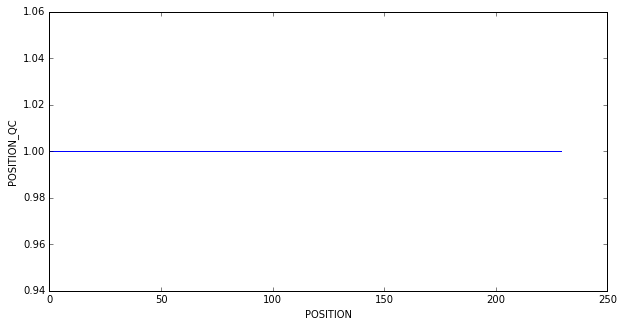

In [68]:
ds['POSITION_QC'].plot(aspect=2, size=5)

In this case, all positions are considered 'good' so we skip any further data selection to overlook not-good data.

## 2. Animating a profiler trajectory with folium

In [69]:
lats = ds['LATITUDE'].values.tolist()
lons = ds['LONGITUDE'].values.tolist()
times = ds['TIME'].values.tolist()

In [70]:
mean_lat = np.mean(lats)
mean_lon = np.mean(lons)

In [71]:
profiler = {
    'type': 'Feature',
    'geometry': {
        'type': 'LineString',
        'coordinates': []
    },
    'properties': {
        'times': [],
        'variable': []
    }
}

In [72]:
for time, lat, lon in zip(times, lats, lons) :
    unix_timestamp = int(str(time)[:13])
    profiler['properties']['times'].append(unix_timestamp)
    profiler['geometry']['coordinates'].append([lon,lat])

In [73]:
view = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)
marker = plugins.TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': [profiler],
}, period='P1D', add_last_point=True, loop=False).add_to(view)
view

Did you know about the <a href="https://ars.els-cdn.com/content/image/1-s2.0-S0952197614002322-gr9.jpg" target="_balnk">Phelops Gyre</a>?